In [ ]:
!pip install rdkit

#Section 1. - Importing and preprocessing the data

## Section 1.1 - Imporing the data and adding additional descriptors using RDKit module

Dataset: https://github.com/deepchem/deepchem/blob/master/datasets/delaney-processed.csv

Apart from the descriptors which where ... I added three additional:
Number of H-Bond Acceptors,
Number of heavy atoms,
Topological Polar surface area.

To summarize

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

# Loading the dataset
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
data = pd.read_csv(url)

data['mol'] = data['smiles'].apply(Chem.MolFromSmiles) # Converting SMILES to RDKit Mol objects

# Calculating RDKit descriptors
def calculate_descriptors_data(mol):
    descriptors = {
        'Number of H-Bond Acceptors': Descriptors.NumHAcceptors(mol),
        'Number of heavy atoms': Descriptors.HeavyAtomCount(mol),
    }
    return pd.Series(descriptors)

descriptor_df = data['mol'].apply(calculate_descriptors_data)

data = pd.concat([data, descriptor_df], axis=1)
data.rename(columns={'Polar Surface Area': 'Topological Polar surface area'}, inplace=True) # Renaming one of the columns for the sake of accuracy

data.dropna(inplace=True) # Dropping molecules that couldn't be processed

##Section 1.2 Explortory data analysis

###Section 1.2.1 Correlation of individual desciptors with measured solubility

As may be seen below there are 3 features which are somewhat correlated to the molecules solubility. Namely number of rings and heavy atoms inside of a molecule and molecular weight of a molecule.

Negative correlation of the mentioned three features with molecules solubility is rather unsuprising.

In [ ]:
data.drop(columns=['Compound ID', 'ESOL predicted log solubility in mols per litre','mol', 'smiles' ], inplace = True)

In [ ]:
# Compute correlation of all columns with 'measured log solubility in mols per litre'
correlation_matrix = data.corr()

# Extract correlations with the target variable
solubility_correlation = correlation_matrix['measured log solubility in mols per litre'].sort_values(ascending=False)

print(solubility_correlation)

measured log solubility in mols per litre    1.000000
Number of H-Bond Donors                      0.209429
Topological Polar surface area               0.123210
Number of H-Bond Acceptors                   0.055728
Minimum Degree                              -0.130445
Number of Rotatable Bonds                   -0.244256
Number of Rings                             -0.512279
Number of heavy atoms                       -0.585638
Molecular Weight                            -0.640189
Name: measured log solubility in mols per litre, dtype: float64


###Section 1.2.2 Visualizing the correlations

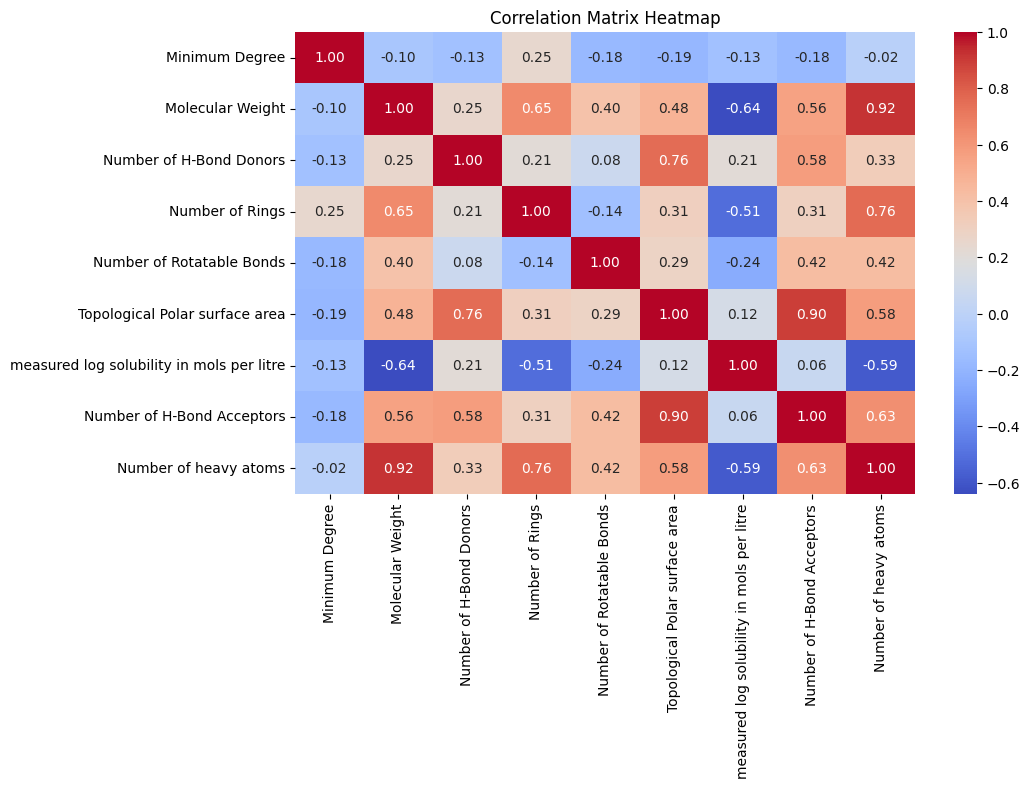

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

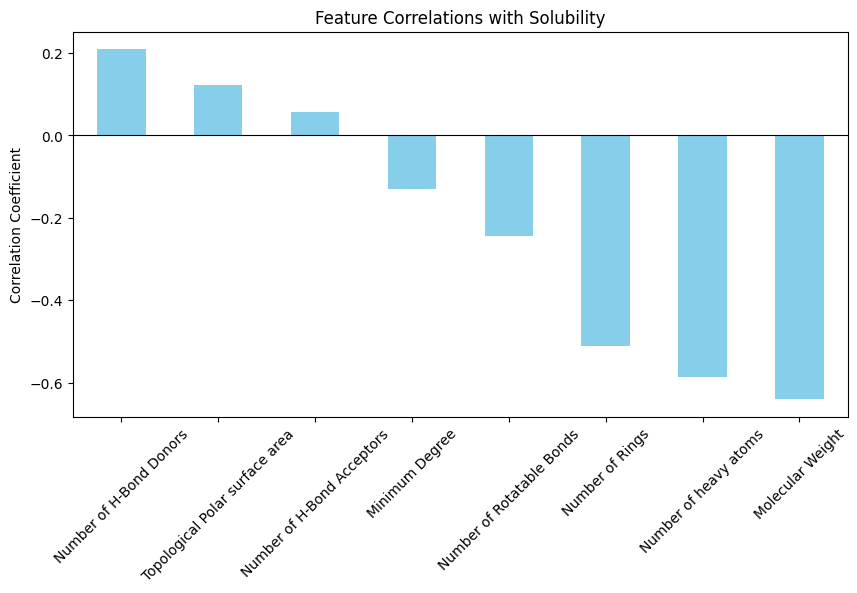

In [ ]:
# Drop the correlation of solubility with itself
solubility_correlation = solubility_correlation.drop(labels=['measured log solubility in mols per litre'])

# Plot the correlations
plt.figure(figsize=(10, 5))
solubility_correlation.plot(kind='bar', color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Feature Correlations with Solubility")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.show()

## Section 1.3 Data preprocessing

Preprocessing consist only of Standardization of Molecular weight, TPSA

In [ ]:
dataset = data[['Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds',
       'measured log solubility in mols per litre',
       'Number of H-Bond Acceptors', 'Number of heavy atoms',
       'Topological Polar surface area']]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# List of columns to standardize
cols_to_standardize = ['Molecular Weight', 'Number of heavy atoms', 'Topological Polar surface area']

# Fit the scaler on the dataset
scaler.fit(dataset[cols_to_standardize])

# Transform all selected columns at once
dataset.loc[:, cols_to_standardize] = scaler.transform(dataset[cols_to_standardize]).astype('float64')

<ipython-input-8-2c7d8f4e1fd0>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.72125107  0.24872273 -0.33304864 ... -0.1876058  -1.2057057
  0.83049411]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[:, cols_to_standardize] = scaler.transform(dataset[cols_to_standardize]).astype('float64')


In [ ]:
dataset

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,measured log solubility in mols per litre,Number of H-Bond Acceptors,Number of heavy atoms,Topological Polar surface area
0,2.468485,7,3,7,-0.770,12,2.721251,4.734437
1,-0.026410,1,2,2,-3.300,2,0.248723,0.208300
2,-0.503445,0,0,4,-2.060,1,-0.333049,-0.503363
3,0.724658,0,5,0,-7.870,0,1.266823,-0.986004
4,-1.166532,0,1,0,-1.330,1,-1.205706,-0.986004
...,...,...,...,...,...,...,...,...
1123,-0.063842,0,0,0,-1.710,0,-0.914820,-0.986004
1124,0.149270,1,0,1,0.106,5,0.103280,1.021466
1125,0.413097,0,0,7,-3.091,5,-0.187606,-0.464061
1126,-1.283307,0,0,1,-3.180,0,-1.205706,-0.986004


In [ ]:
# Defining features (X) and target (y)
X = dataset[['Molecular Weight', 'Number of H-Bond Donors',
             'Number of H-Bond Acceptors', 'Number of Rings',
             'Number of Rotatable Bonds', 'Number of heavy atoms',
             'Topological Polar surface area']]

y = dataset['measured log solubility in mols per litre']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X

,Molecular Weight,Number of H-Bond Donors,Number of H-Bond Acceptors,Number of Rings,Number of Rotatable Bonds,Number of heavy atoms,Topological Polar surface area
0,2.468485,7,12,3,7,2.721251,4.734437
1,-0.026410,1,2,2,2,0.248723,0.208300
2,-0.503445,0,1,0,4,-0.333049,-0.503363
3,0.724658,0,0,5,0,1.266823,-0.986004
4,-1.166532,0,1,1,0,-1.205706,-0.986004
...,...,...,...,...,...,...,...
1123,-0.063842,0,0,0,0,-0.914820,-0.986004
1124,0.149270,1,5,0,1,0.103280,1.021466
1125,0.413097,0,5,0,7,-0.187606,-0.464061
1126,-1.283307,0,0,0,1,-1.205706,-0.986004


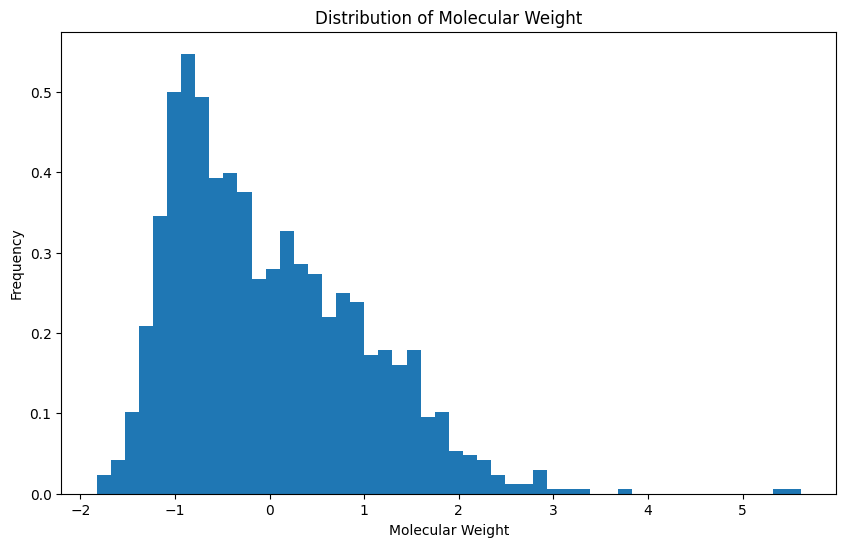

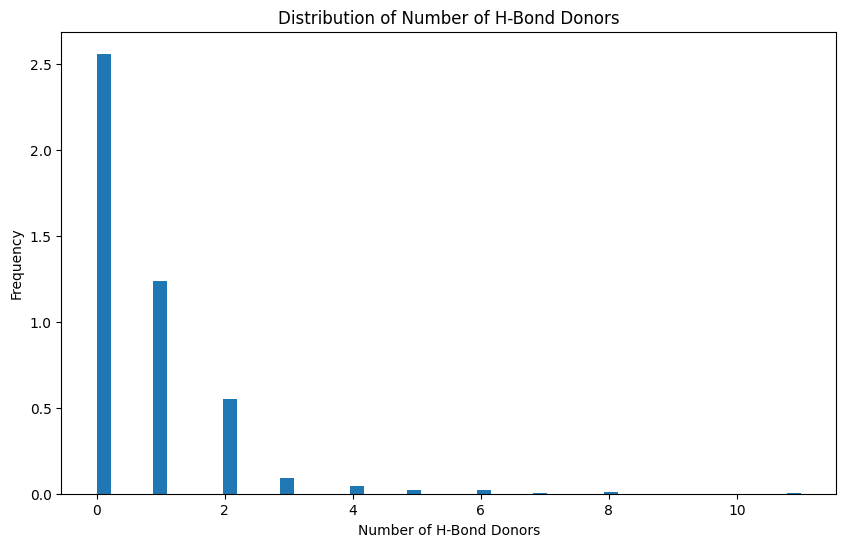

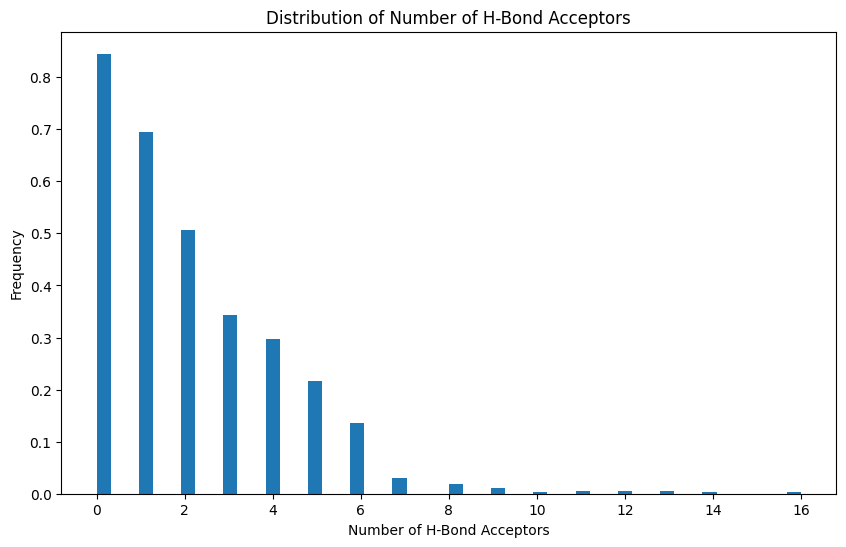

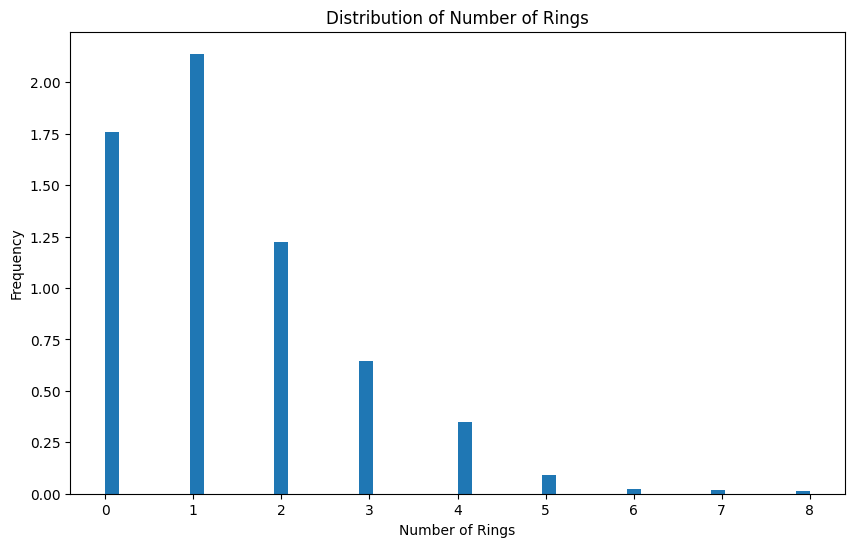

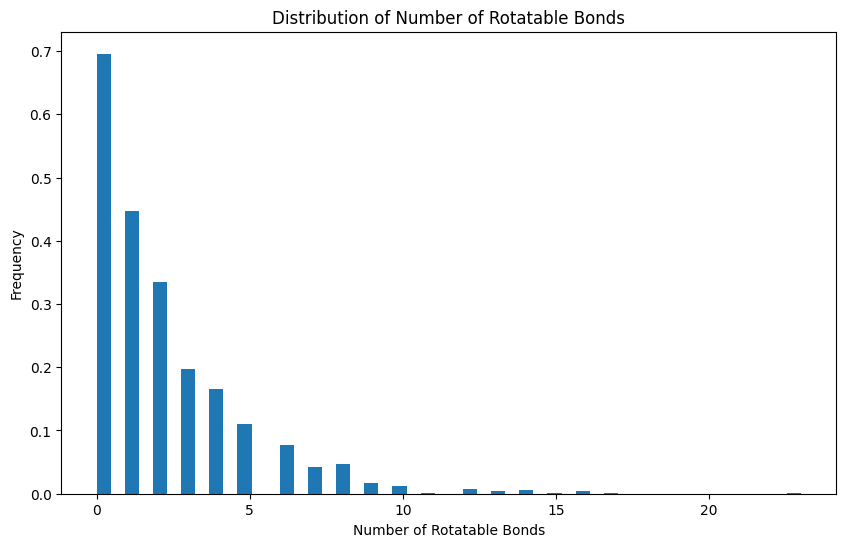

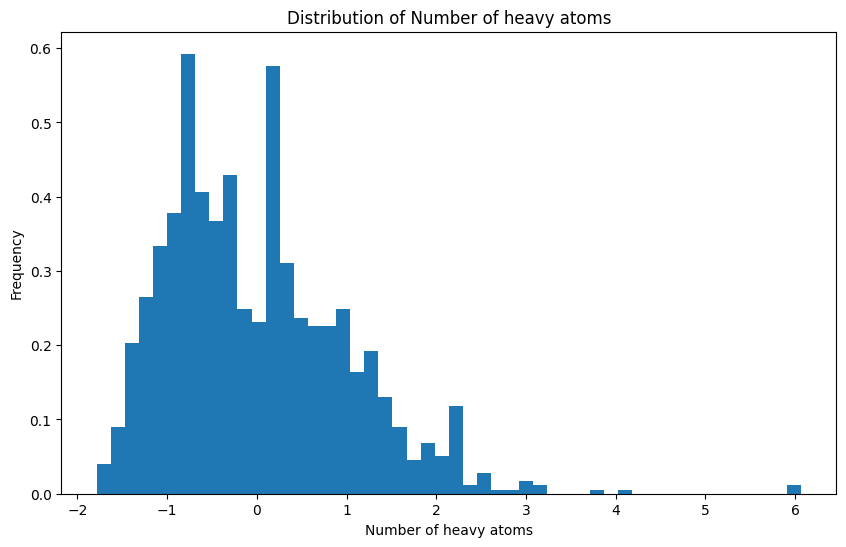

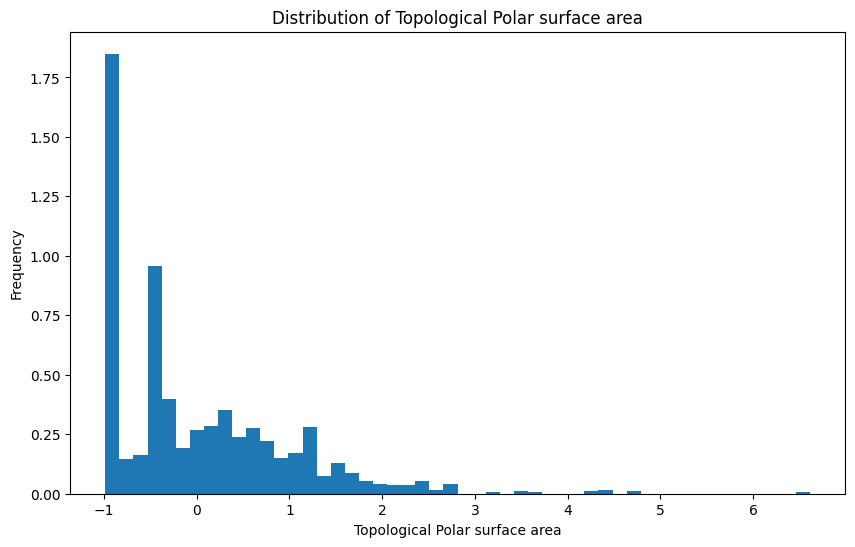

In [ ]:
import matplotlib.pyplot as plt

descriptors = ['Molecular Weight', 'Number of H-Bond Donors',
             'Number of H-Bond Acceptors', 'Number of Rings',
             'Number of Rotatable Bonds', 'Number of heavy atoms',
             'Topological Polar surface area']

for descriptor in descriptors:
  plt.figure(figsize=(10, 6))
  plt.title(f'Distribution of {descriptor}')
  plt.xlabel(descriptor)
  plt.ylabel('Frequency')
  plt.hist(dataset[[descriptor]], density=True, bins=50)

#Section 2 - Generating test data from SMILES

In [ ]:
from sklearn.preprocessing import StandardScaler
from rdkit.Chem import rdMolDescriptors

# Calculating descriptors for molecules in SMILE format
def calculate_descriptors(mol):
    descriptors = {
        'Molecular Weight': Descriptors.MolWt(mol),
        'Number of H-Bond Donors': Descriptors.NumHDonors(mol),
        'Number of H-Bond Acceptors': Descriptors.NumHAcceptors(mol),
        'Number of Rings': rdMolDescriptors.CalcNumRings(mol),
        'Number of Rotatable Bonds': rdMolDescriptors.CalcNumRotatableBonds(mol),
        'Number of heavy atoms': Descriptors.HeavyAtomCount(mol),
        'Topological Polar surface area': rdMolDescriptors.CalcTPSA(mol),
    }
    return pd.Series(descriptors)

In [ ]:
smilesList = [
    'C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'CCCCCC',
    'CCCCCCC', 'CCN', 'CC(=O)O', 'CCOCC', 'CC(=O)CC',
    'CC(=O)OCC', 'CCCCO', 'C(C(=O)O)C(N)C', 'CCCCCO'
]

# The solubities in a form of log([mol of substance]/[litre of H2O]). Experimental measurements based on the literature.
log_solubilities = [-2.82, -2.70,	-2.82,	-2.98,	-2.65,	-3.96,	-4.53,	-1.57,	1.00,	-0.12,	0.44,	-0.10,	-0.01,	0.79,	-0.61]
# For refernece - "Yalkowsky, S.H., He, Yan, Jain, P. Handbook of Aqueous Solubility Data Second Edition. CRC Press, Boca Raton, FL 2010"


In [ ]:
# Creat a SMILES dataframe
smilesDF = pd.DataFrame(smilesList, columns=['smiles'])

# Convert SMILES to RDKit Mol objects
smilesDF['mol'] = smilesDF['smiles'].apply(Chem.MolFromSmiles)

# Calculate the descriptors in a seperate dataframe
descriptors_df = smilesDF['mol'].apply(calculate_descriptors)

# Merge the descripotrs and mol dataframe
testDFfromSMILES = pd.concat([smilesDF.drop(columns=['mol', 'smiles']), descriptors_df], axis=1)

# Standardization of desired colums
testDFfromSMILES.loc[:, cols_to_standardize] = scaler.transform(testDFfromSMILES[cols_to_standardize]).astype('float64')

In [ ]:
testDFfromSMILES

,Molecular Weight,Number of H-Bond Donors,Number of H-Bond Acceptors,Number of Rings,Number of Rotatable Bonds,Number of heavy atoms,Topological Polar surface area
0,-1.829676,0.0,0.0,0.0,0.0,-1.787477,-0.986004
1,-1.693084,0.0,0.0,0.0,0.0,-1.642034,-0.986004
2,-1.556492,0.0,0.0,0.0,0.0,-1.496591,-0.986004
3,-1.419900,0.0,0.0,0.0,1.0,-1.351149,-0.986004
4,-1.283307,0.0,0.0,0.0,2.0,-1.205706,-0.986004
5,-1.146715,0.0,0.0,0.0,3.0,-1.060263,-0.986004
6,-1.010123,0.0,0.0,0.0,4.0,-0.914820,-0.986004
7,-1.546871,1.0,1.0,0.0,0.0,-1.496591,-0.250308
8,-1.401125,1.0,1.0,0.0,0.0,-1.351149,0.068625
9,-1.264104,0.0,1.0,0.0,2.0,-1.205706,-0.725033


#Section 3 - Feeding ML algorithms with data

##Section 3.1 - Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_smiles_scaled = scaler.transform(testDFfromSMILES)

linear = LinearRegression()
linear.fit(X_train_scaled, y_train)

# Making predictions
y_pred = linear.predict(X_test_scaled)
y_pred_smiles = linear.predict(X_smiles_scaled)

# Evaluating the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_smiles = r2_score(log_solubilities, y_pred_smiles)

print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'R² Score for SMILES: {r2_smiles}')

RMSE: 1.373924316856718
R² Score: 0.7093333116316951
R² Score for SMILES: 0.29229246717561164


##Section 3.2 - Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeRegressor

results_tree = {}

for criterion in ['squared_error', 'absolute_error']:
  for max_depth in [None, 10, 100]:
    tree = DecisionTreeRegressor(criterion=criterion, max_depth=max_depth)
    tree.fit(X_train, y_train)

    #Making predictions
    y_pred = tree.predict(X_test)
    y_pred_smiles = tree.predict(testDFfromSMILES)

    #Evaluating the models performance
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_smiles = r2_score(log_solubilities, y_pred_smiles)

    #Saving results
    results_tree[(criterion, max_depth)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

    print(f'Decision tree regressor with hyperparameters criterion = {criterion} and max_depth = {max_depth}')
    print(f'RMSE: {rmse}')
    print(f'R² Score: {r2}')
    print(f'R² Score for SMILES: {r2_smiles}')

#Finding the best model, based on r2
best_model_tree = max(results_tree, key=lambda k: results_tree[k]['r2'])
best_r2 = results_tree[best_model_tree]['r2']
print(f"#\nBest model: {best_model_tree}, R² score: {best_r2}")

#Finding the best model, based on r2_smiles
best_model_smiles = max(results_tree, key=lambda k: results_tree[k]['r2_smiles'])
best_r2_smiles = results_tree[best_model_smiles]['r2_smiles']
print(f"#\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")

Decision tree regressor with hyperparameters criterion = squared_error and max_depth = None
RMSE: 1.3927781892828295
R² Score: 0.7053445965374358
R² Score for SMILES: 0.6201260796127146
Decision tree regressor with hyperparameters criterion = squared_error and max_depth = 10
RMSE: 1.1023726861302252
R² Score: 0.76678262834869
R² Score for SMILES: 0.6066866452377075
Decision tree regressor with hyperparameters criterion = squared_error and max_depth = 100
RMSE: 1.3910672125129182
R² Score: 0.7057065698612088
R² Score for SMILES: 0.6657097275677921
Decision tree regressor with hyperparameters criterion = absolute_error and max_depth = None
RMSE: 1.1087667378318584
R² Score: 0.7654299062150419
R² Score for SMILES: 0.678159492631142
Decision tree regressor with hyperparameters criterion = absolute_error and max_depth = 10
RMSE: 0.996575706858407
R² Score: 0.789164980292692
R² Score for SMILES: 0.5946365882360817
Decision tree regressor with hyperparameters criterion = absolute_error and ma

##Section 3.3 - Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

results_rf = {}

for n_estimators in [10, 100, 1000]:
  for max_depth in [None, 10, 100]:
    forest = RandomForestRegressor(n_estimators=n_estimators, criterion='squared_error', max_depth=None)
    forest.fit(X_train, y_train)

    # Making predictions
    y_pred = forest.predict(X_test)
    y_pred_smiles = forest.predict(testDFfromSMILES)

    # Evaluating the model
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_smiles = r2_score(log_solubilities, y_pred_smiles)

    #Saving results
    results_rf[(n_estimators, max_depth)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

    print('################')
    print(f'Random forest regressor with hyperparameters n_estimators = {n_estimators} and max_depth = {max_depth}')
    print(f'RMSE: {rmse}')
    print(f'R² Score: {r2}')
    print(f'R² Score for SMILES: {r2_smiles}')

best_model_rf = max(results_rf, key=lambda k: results_rf[k]['r2'])
best_r2 = results_rf[best_model_rf]['r2']
print(f"#\nBest model: {best_model_rf}, R² score: {best_r2}")

best_model_smiles = max(results_rf, key=lambda k: results_rf[k]['r2_smiles'])
best_r2_smiles = results_rf[best_model_smiles]['r2_smiles']
print(f"#\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")

################
Random forest regressor with hyperparameters n_estimators = 10 and max_depth = None
RMSE: 0.7357572527993755
R² Score: 0.8443435919356692
R² Score for SMILES: 0.6303827919576267
################
Random forest regressor with hyperparameters n_estimators = 10 and max_depth = 10
RMSE: 0.739539853979246
R² Score: 0.8435433468676683
R² Score for SMILES: 0.602509608893633
################
Random forest regressor with hyperparameters n_estimators = 10 and max_depth = 100
RMSE: 0.67818264823268
R² Score: 0.8565240442634966
R² Score for SMILES: 0.6054952459820053
################
Random forest regressor with hyperparameters n_estimators = 100 and max_depth = None
RMSE: 0.6970531850653935
R² Score: 0.8525318036563534
R² Score for SMILES: 0.5883052143122067
################
Random forest regressor with hyperparameters n_estimators = 100 and max_depth = 10
RMSE: 0.7008419783385776
R² Score: 0.8517302485924266
R² Score for SMILES: 0.5909365191346991
################
Random forest r

##Section 3.4 - Support Vector Machine

In [ ]:
from sklearn.svm import SVR

results_svr = {}

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_smiles_scaled = scaler.transform(testDFfromSMILES)

for kernel in ['linear', 'rbf', 'poly']:
  for C in [0.1, 1, 10]:
    # Define the SVR model with RBF kernel
    svr = SVR(kernel=kernel, C=C, epsilon=0.1)

    # Train the model
    svr.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svr.predict(X_test_scaled)
    y_pred_smiles = svr.predict(X_smiles_scaled)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_smiles = r2_score(log_solubilities, y_pred_smiles)

    #Saving results
    results_svr[(kernel, C)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

    print(f'RMSE: {rmse}')
    print(f'R² Score: {r2}')
    print(f'R² Score for SMILES: {r2_smiles}')

best_model_svr = max(results_svr, key=lambda k: results_svr[k]['r2'])
best_r2 = results_svr[best_model_svr]['r2']
print(f"#\nBest model: {best_model_svr}, R² score: {best_r2}")

best_model_smiles = max(results_svr, key=lambda k: results_svr[k]['r2_smiles'])
best_r2_smiles = results_svr[best_model_smiles]['r2_smiles']
print(f"#\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")

RMSE: 1.3710265572332705
R² Score: 0.7099463600966658
R² Score for SMILES: 0.27352220359309787
RMSE: 1.388830868712584
R² Score: 0.7061796895509331
R² Score for SMILES: 0.2673936509633935
RMSE: 1.389781434055076
R² Score: 0.7059785884591264
R² Score for SMILES: 0.2666445205482145
RMSE: 1.3927084177628206
R² Score: 0.7053593573626242
R² Score for SMILES: 0.4937176447541203
RMSE: 0.8414622546280771
R² Score: 0.8219806986899865
R² Score for SMILES: 0.5132898964936353
RMSE: 0.720082228285245
R² Score: 0.8476597916780524
R² Score for SMILES: 0.5096364659681824
RMSE: 4.57755154298991
R² Score: 0.031575661401690436
R² Score for SMILES: 0.0476375760277169
RMSE: 4.281004539856019
R² Score: 0.09431298564068091
R² Score for SMILES: 0.18736227168786246
RMSE: 4.235310103965466
R² Score: 0.10398007588299585
R² Score for SMILES: 0.24131807968154395
#
Best model: ('rbf', 10), R² score: 0.8476597916780524
#
Best model [foreign data]: ('rbf', 1), R² score: 0.5132898964936353


##Section 3.5 - Multi Layer Perceptron

In [ ]:
# Scaling the data

X_train_scaled = X_train
X_test_scaled = X_test
X_smiles_scaled = testDFfromSMILES


results_mlp = {}

for hidden_layer_sizes in [(64, 32), (128, 64), (256, 128)]:
    for activation in ['relu', 'tanh']:
        for solver in ['adam', 'sgd']:
            # Defining and training the MLPRegressor model
            mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=1000, alpha = 0.01, random_state=42)
            mlp.fit(X_train_scaled, y_train)

            # Making predictions
            y_pred = mlp.predict(X_test_scaled)
            y_pred_smiles = mlp.predict(X_smiles_scaled)

            # Evaluating the model
            rmse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            r2_smiles = r2_score(log_solubilities, y_pred_smiles)

            # Saving results
            results_mlp[(hidden_layer_sizes, activation, solver)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

            print(f'MLP regressor with hyperparameters hidden_layer_sizes= {hidden_layer_sizes}, activation = {activation} and solver = {solver}')
            print(f'RMSE: {rmse}')
            print(f'R² Score: {r2}')
            print(f'R² Score for SMILES: {r2_smiles}')

best_model = max(results_mlp, key=lambda k: results_mlp[k]['r2'])
best_r2 = results_mlp[best_model]['r2']
print(f"\nBest model: {best_model}, R² score: {best_r2}")

best_model_smiles = max(results_mlp, key=lambda k: results_mlp[k]['r2_smiles'])
best_r2_smiles = results_mlp[best_model_smiles]['r2_smiles']
print(f"\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")


MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = relu and solver = adam
RMSE: 0.6120653782677352
R² Score: 0.8705117782812124
R² Score for SMILES: 0.5307230473317721
MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = relu and solver = sgd
RMSE: 0.7028725443822417
R² Score: 0.851300663134055
R² Score for SMILES: 0.5413132051608944
MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = tanh and solver = adam
RMSE: 0.6322115019309187
R² Score: 0.8662496752113483
R² Score for SMILES: 0.548708179405502
MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = tanh and solver = sgd
RMSE: 0.6992481057073594
R² Score: 0.8520674474276995
R² Score for SMILES: 0.545307431568207
MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = relu and solver = adam
RMSE: 0.6718166633316087
R² Score: 0.8578708285999368
R² Score for SMILES: 0.44998511487115145


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = relu and solver = sgd
RMSE: 0.7239228786153984
R² Score: 0.8468472657630877
R² Score for SMILES: 0.5610541828171114
MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = tanh and solver = adam
RMSE: 0.6070772020960601
R² Score: 0.87156707414506
R² Score for SMILES: 0.4923181246560455
MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = tanh and solver = sgd
RMSE: 0.7004638895770183
R² Score: 0.8518102368471532
R² Score for SMILES: 0.515930698739591
MLP regressor with hyperparameters hidden_layer_sizes= (256, 128), activation = relu and solver = adam
RMSE: 0.7060241009455267
R² Score: 0.8506339215252077
R² Score for SMILES: 0.5628522082102743
MLP regressor with hyperparameters hidden_layer_sizes= (256, 128), activation = relu and solver = sgd
RMSE: 0.7051878229568157
R² Score: 0.8508108440460129
R² Score for SMILES: 0.5631491075268809
MLP regressor with hyper

#Section 4 - Analyzing the results

##Section 4.1 - Decision tree classifier

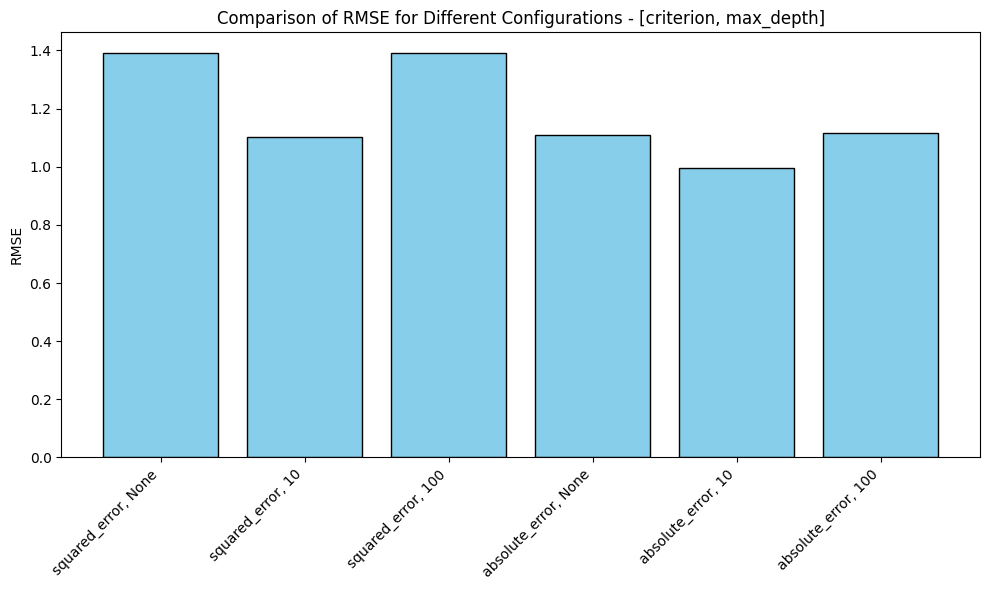

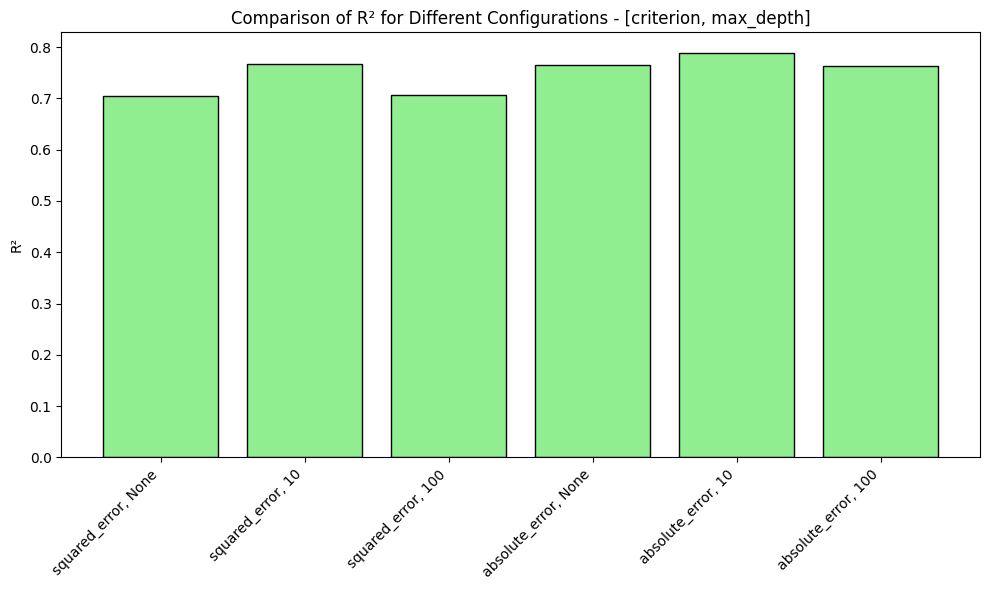

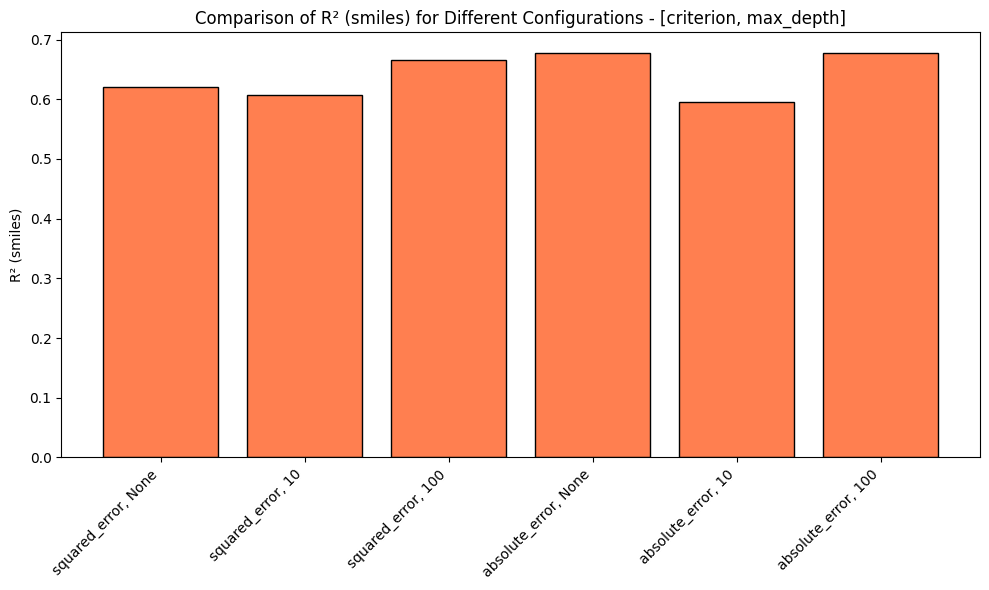

In [ ]:
# Data processing
labels = [f"{key[0]}, {key[1]}" for key in results_tree.keys()]
rmse_values = [value['rmse'] for value in results_tree.values()]
r2_values = [value['r2'] for value in results_tree.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_tree.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [criterion, max_depth]')
plt.tight_layout()
plt.show()

# Plot 2: R2
plt.figure(figsize=(10, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Different Configurations - [criterion, max_depth]')
plt.tight_layout()
plt.show()

# Plot 3: R2_smiles
plt.figure(figsize=(10, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Different Configurations - [criterion, max_depth]')
plt.tight_layout()
plt.show()

##Section 4.2 - Random Forest Regression

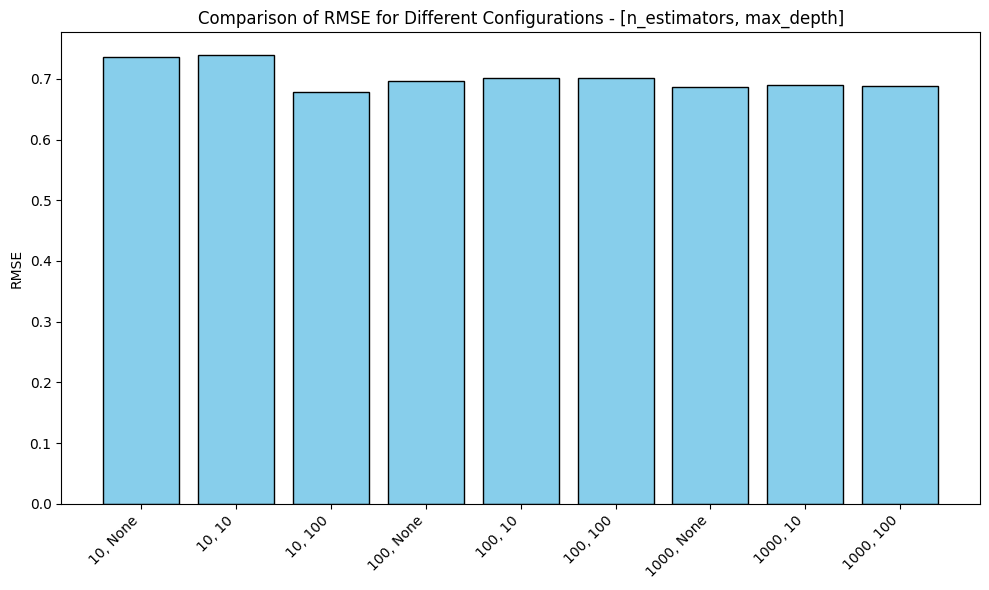

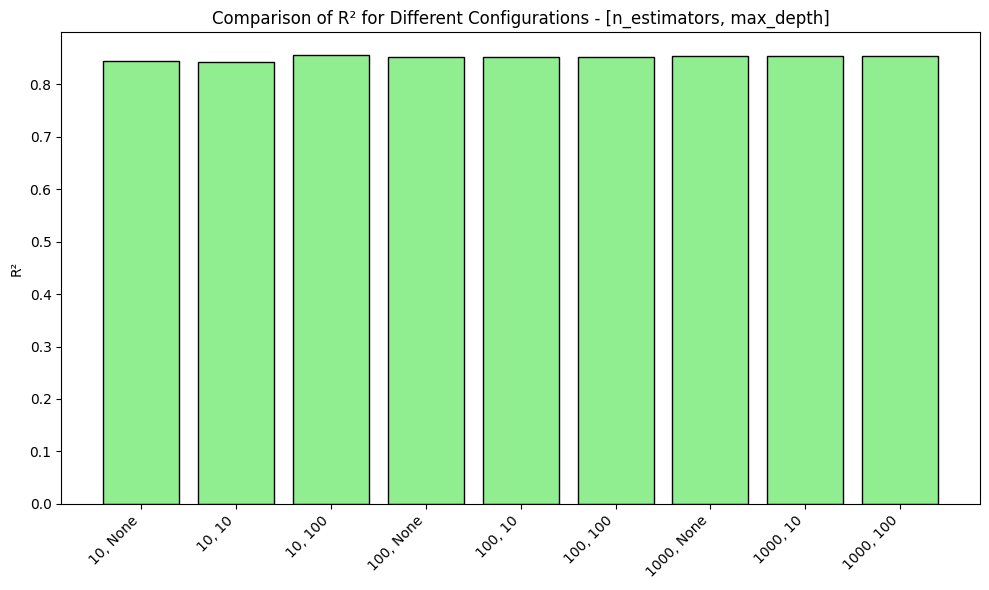

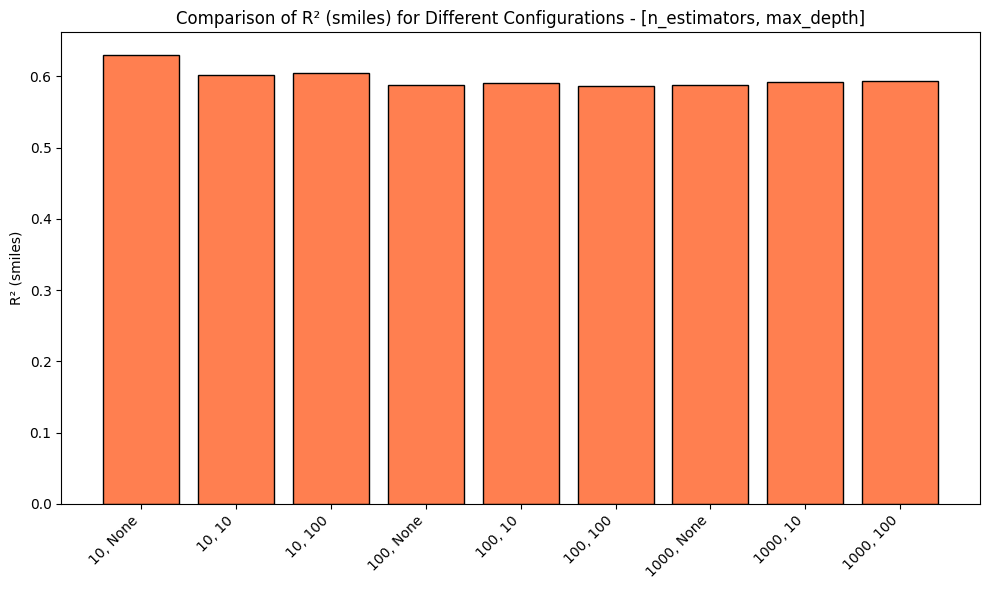

In [ ]:
# Data processing
labels = [f"{key[0]}, {key[1]}" for key in results_rf.keys()]
rmse_values = [value['rmse'] for value in results_rf.values()]
r2_values = [value['r2'] for value in results_rf.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_rf.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [n_estimators, max_depth]')
plt.tight_layout()
plt.show()

# Plot 2: R²
plt.figure(figsize=(10, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Different Configurations - [n_estimators, max_depth]')
plt.tight_layout()
plt.show()

# Plot 3: R²_smiles
plt.figure(figsize=(10, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Different Configurations - [n_estimators, max_depth]')
plt.tight_layout()
plt.show()

##Section 4.3 - Support Vector Machine

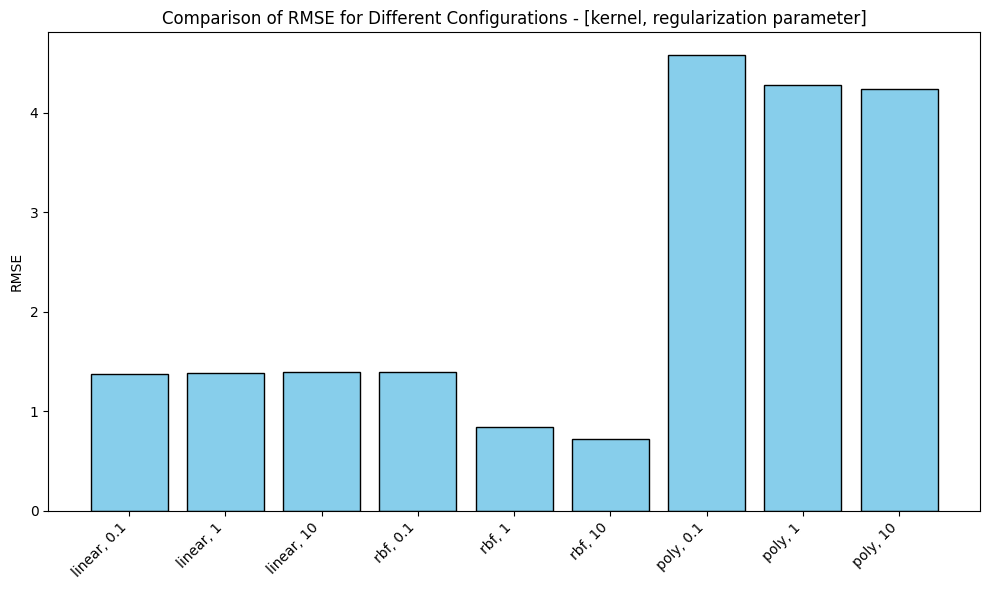

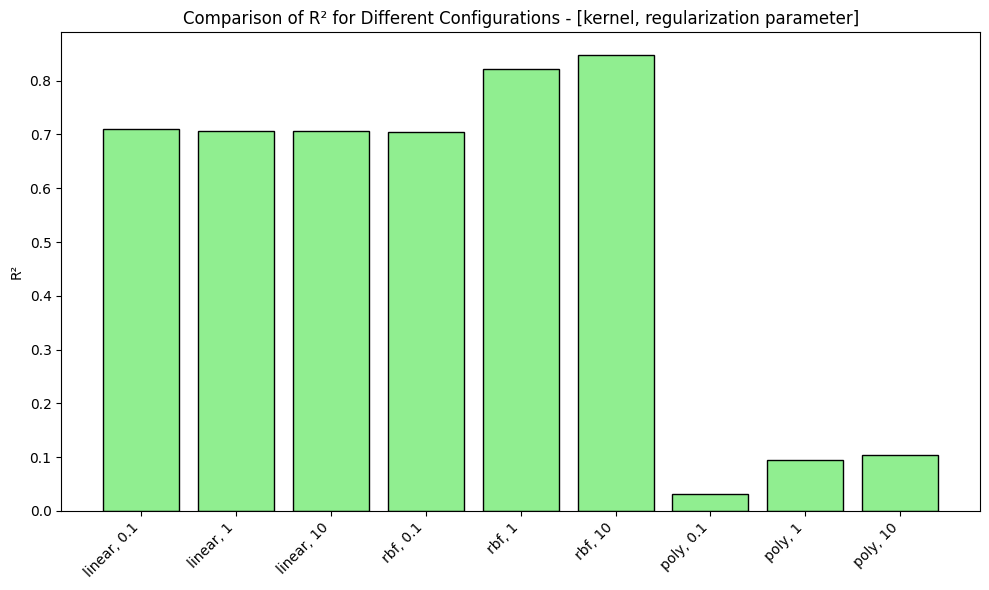

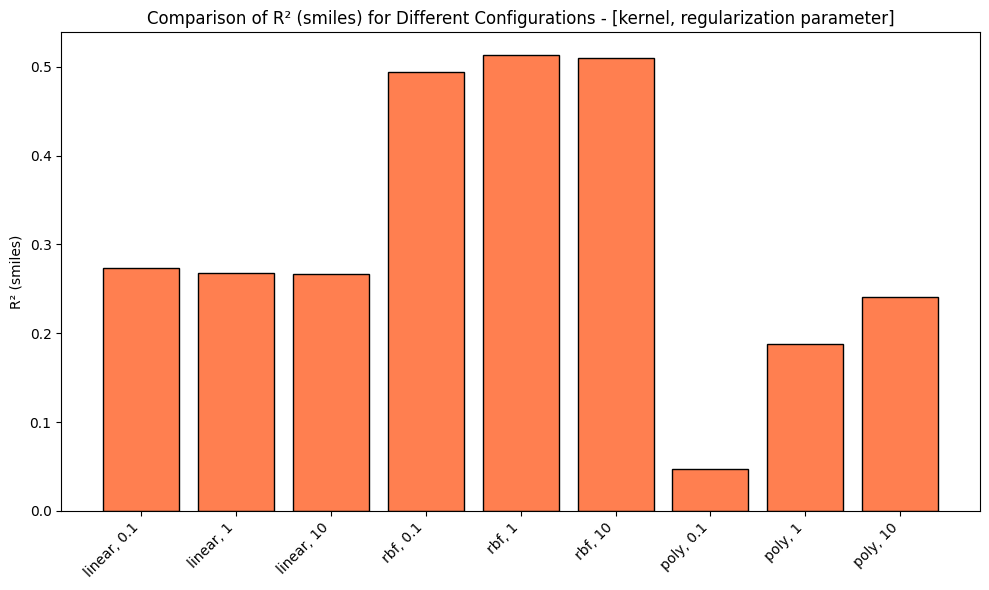

In [ ]:
# Data processing
labels = [f"{key[0]}, {key[1]}" for key in results_svr.keys()]
rmse_values = [value['rmse'] for value in results_svr.values()]
r2_values = [value['r2'] for value in results_svr.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_svr.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [kernel, regularization parameter]')
plt.tight_layout()
plt.show()

# Plot 2: R²
plt.figure(figsize=(10, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Different Configurations - [kernel, regularization parameter]')
plt.tight_layout()
plt.show()

# Plot 3: R²_smiles
plt.figure(figsize=(10, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Different Configurations - [kernel, regularization parameter]')
plt.tight_layout()
plt.show()

##Section 4.4 - Multi Layer Perceptron

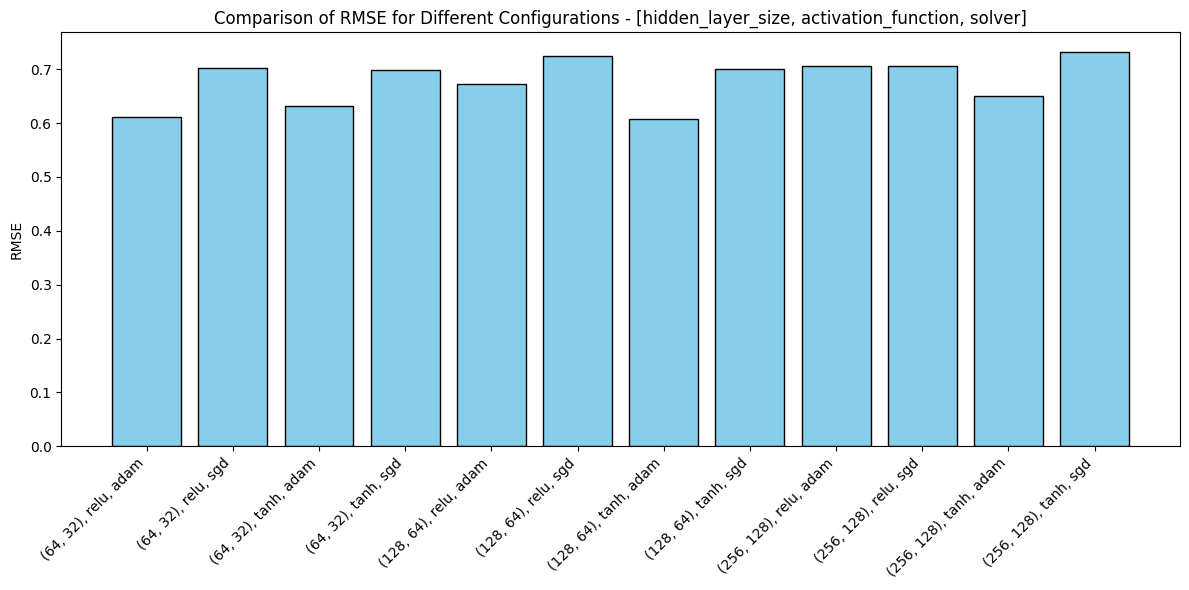

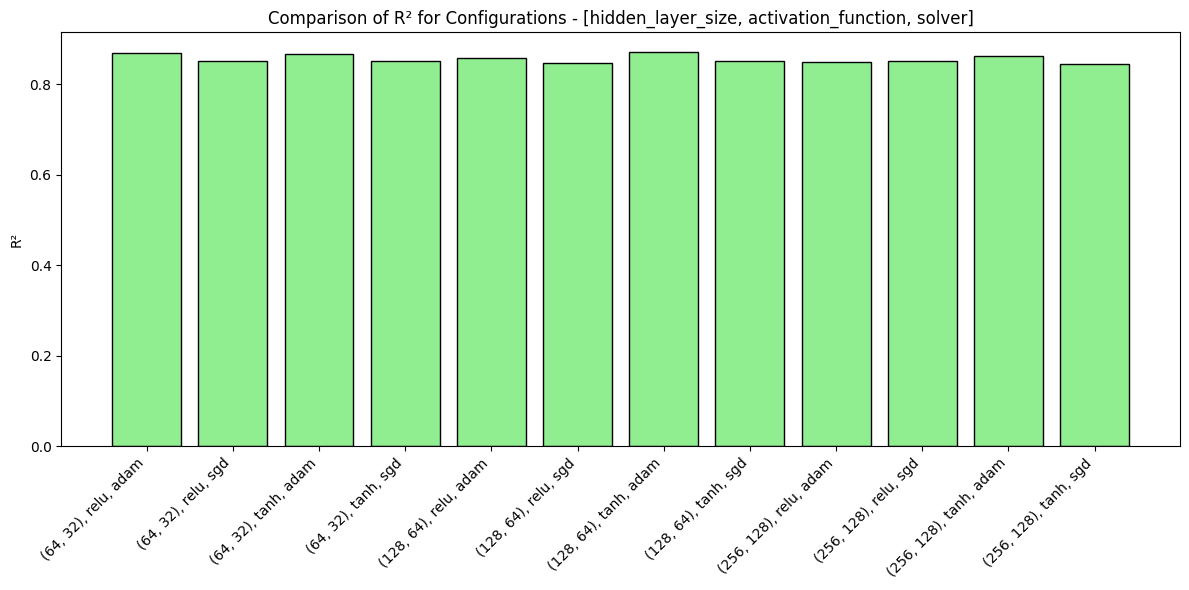

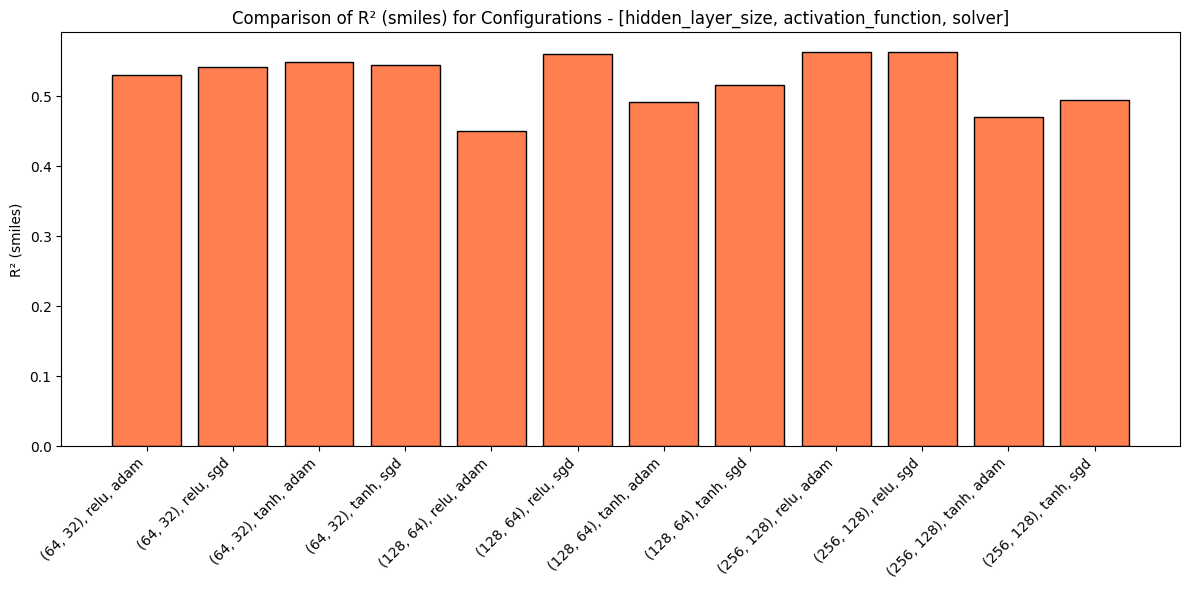

In [ ]:
# Data processing to adapt for three hyperparameters
labels = [f"{key[0]}, {key[1]}, {key[2]}" for key in results_mlp.keys()]
rmse_values = [value['rmse'] for value in results_mlp.values()]
r2_values = [value['r2'] for value in results_mlp.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_mlp.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(12, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [hidden_layer_size, activation_function, solver]')
plt.tight_layout()
plt.show()

# Plot 2: R²
plt.figure(figsize=(12, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Configurations - [hidden_layer_size, activation_function, solver]')
plt.tight_layout()
plt.show()

# Plot 3: R²_smiles
plt.figure(figsize=(12, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Configurations - [hidden_layer_size, activation_function, solver]')
plt.tight_layout()
plt.show()

In [ ]:
results_mlp

{((64, 32), 'relu', 'adam'): {'rmse': 0.6120653782677352,
  'r2': 0.8705117782812124,
  'r2_smiles': 0.5307230473317721},
 ((64, 32), 'relu', 'sgd'): {'rmse': 0.7028725443822417,
  'r2': 0.851300663134055,
  'r2_smiles': 0.5413132051608944},
 ((64, 32), 'tanh', 'adam'): {'rmse': 0.6322115019309187,
  'r2': 0.8662496752113483,
  'r2_smiles': 0.548708179405502},
 ((64, 32), 'tanh', 'sgd'): {'rmse': 0.6992481057073594,
  'r2': 0.8520674474276995,
  'r2_smiles': 0.545307431568207},
 ((128, 64), 'relu', 'adam'): {'rmse': 0.6718166633316087,
  'r2': 0.8578708285999368,
  'r2_smiles': 0.44998511487115145},
 ((128, 64), 'relu', 'sgd'): {'rmse': 0.7239228786153984,
  'r2': 0.8468472657630877,
  'r2_smiles': 0.5610541828171114},
 ((128, 64), 'tanh', 'adam'): {'rmse': 0.6070772020960601,
  'r2': 0.87156707414506,
  'r2_smiles': 0.4923181246560455},
 ((128, 64), 'tanh', 'sgd'): {'rmse': 0.7004638895770183,
  'r2': 0.8518102368471532,
  'r2_smiles': 0.515930698739591},
 ((256, 128), 'relu', 'adam')